# Tâche 2 : Estimation de l'Âge à partir d'une Photo

Ce notebook a pour objectif de résoudre la deuxième tâche du challenge ANIP : prédire l'âge d'une personne à partir d'une image faciale.

## Objectif

Développer une IA capable de prédire l'âge d'une personne à partir d'une image avec la meilleure précision possible.

## Stratégie adoptée

Notre approche sera méthodique et basée sur les meilleures pratiques :

1. **Analyse Exploratoire des Données (AED)** : Comprendre la distribution des âges, sexes, et qualité des images
2. **Préparation des données** : Parsing des noms de fichiers, normalisation, augmentation
3. **Modélisation avec Transfer Learning** : Utilisation de modèles pré-entraînés optimisés pour la régression d'âge
4. **Évaluation et optimisation** : Métriques MAE/RMSE, validation croisée, tuning
5. **Prédiction finale** : Application sur les 200 images de test et génération de la soumission

In [26]:
# Importation des bibliothèques fondamentales
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
print("✅ Bibliothèques de base importées.")

✅ Bibliothèques de base importées.


## 1. Configuration de l'Environnement

Définition des chemins et vérification de l'accès aux données de la tâche 2.

In [27]:
# Définition des chemins principaux pour la tâche 2
BASE_DIR = Path('..')
DATA_ROOT = BASE_DIR / 'dataset_tache_2' / 'dataset_tache_2'
TRAIN_DIR = DATA_ROOT / 'train'
TEST_DIR = DATA_ROOT / 'test'  # Les 200 images de test
SUBMISSIONS_DIR = BASE_DIR / 'submissions'

# Créer le dossier de soumissions s'il n'existe pas
SUBMISSIONS_DIR.mkdir(exist_ok=True)

# Vérification de l'existence des chemins
print(f"Dossier racine des données : {DATA_ROOT.resolve()}")
print(f"Dossier des images d'entraînement : {TRAIN_DIR.resolve()}")
print(f"Dossier des images de test : {TEST_DIR.resolve()}")
print(f"Dossier des soumissions : {SUBMISSIONS_DIR.resolve()}")

# Validation avec plusieurs extensions possibles
if not TRAIN_DIR.exists():
    print("\n⚠️ Attention : Le dossier d'entraînement est introuvable.")
else:
    # Chercher avec différentes extensions (minuscules ET majuscules)
    train_files_jpg = list(TRAIN_DIR.glob('*.jpg')) + list(TRAIN_DIR.glob('*.JPG'))
    train_files_jpeg = list(TRAIN_DIR.glob('*.jpeg')) + list(TRAIN_DIR.glob('*.JPEG'))
    train_files_png = list(TRAIN_DIR.glob('*.png')) + list(TRAIN_DIR.glob('*.PNG'))
    train_files = train_files_jpg + train_files_jpeg + train_files_png
    
    print(f"\n📁 Contenu du dossier d'entraînement:")
    print(f"   Images .jpg: {len(train_files_jpg)}")
    print(f"   Images .jpeg: {len(train_files_jpeg)}")
    print(f"   Images .png: {len(train_files_png)}")
    print(f"   Total images: {len(train_files)}")
    
    # Si aucune image trouvée, lister le contenu du dossier
    if len(train_files) == 0:
        all_files = list(TRAIN_DIR.iterdir())
        print(f"\n🔍 Tous les fichiers dans le dossier ({len(all_files)} fichiers):")
        for i, file in enumerate(all_files[:10]):  # Afficher les 10 premiers
            print(f"   {file.name}")
        if len(all_files) > 10:
            print(f"   ... et {len(all_files) - 10} autres fichiers")
    else:
        print(f"\n✅ Dossier d'entraînement trouvé avec {len(train_files)} images")

if not TEST_DIR.exists():
    print("⚠️ Attention : Le dossier de test est introuvable.")
else:
    test_files_jpg = list(TEST_DIR.glob('*.JPG'))
    test_files_jpeg = list(TEST_DIR.glob('*.jpeg'))
    test_files_png = list(TEST_DIR.glob('*.png'))
    test_files = test_files_jpg + test_files_jpeg + test_files_png
    print(f"✅ Dossier de test trouvé avec {len(test_files)} images")

Dossier racine des données : /workspaces/anip-facial-ocr-challenge/dataset_tache_2/dataset_tache_2
Dossier des images d'entraînement : /workspaces/anip-facial-ocr-challenge/dataset_tache_2/dataset_tache_2/train
Dossier des images de test : /workspaces/anip-facial-ocr-challenge/dataset_tache_2/dataset_tache_2/test
Dossier des soumissions : /workspaces/anip-facial-ocr-challenge/submissions

📁 Contenu du dossier d'entraînement:
   Images .jpg: 12420
   Images .jpeg: 0
   Images .png: 0
   Total images: 12420

✅ Dossier d'entraînement trouvé avec 12420 images
⚠️ Attention : Le dossier de test est introuvable.

📁 Contenu du dossier d'entraînement:
   Images .jpg: 12420
   Images .jpeg: 0
   Images .png: 0
   Total images: 12420

✅ Dossier d'entraînement trouvé avec 12420 images
⚠️ Attention : Le dossier de test est introuvable.


## 2. Analyse Exploratoire des Données (AED)

### 2.1 Parsing des noms de fichiers

Les fichiers d'entraînement suivent le format : `XXXXXX_YZWW` où :
- `XXXXXX` : identifiant de la personne
- `Y` : numéro de la photo pour une même personne (à partir de 0)
- `Z` : sexe (M ou F)
- `WW` : âge de la personne

In [28]:
def parse_filename(filename):
    """
    Parse le nom de fichier pour extraire les informations.
    Format: ID_NUMERO[M|F]AGE.jpg où :
    - ID : identifiant de la personne (nombre variable de chiffres)
    - NUMERO : numéro de la photo pour une même personne (nombre variable de chiffres)
    - [M|F] : sexe (M ou F)
    - AGE : âge de la personne (2 chiffres)
    """
    # Enlever l'extension
    name = filename.stem if hasattr(filename, 'stem') else Path(filename).stem
    
    # Pattern regex plus flexible basé sur l'underscore et la lettre M/F
    # Chercher: (chiffres)_(chiffres)[M|F](2 chiffres)
    pattern = r'(\d+)_(\d+)([MF])(\d{2})'
    match = re.match(pattern, name)
    
    if match:
        person_id = match.group(1)
        photo_num = int(match.group(2))
        gender = match.group(3)
        age = int(match.group(4))
        
        return {
            'filename': name + Path(str(filename)).suffix,  # Garder la vraie extension
            'person_id': person_id,
            'photo_num': photo_num,
            'gender': gender,
            'age': age
        }
    else:
        # Debug pour voir ce qui ne marche pas
        print(f"⚠️ Impossible de parser: '{name}' (pattern attendu: ID_NUMERO[M|F]AGE)")
        return None

# Test de la fonction de parsing avec les fichiers trouvés
if 'train_files' in locals() and train_files:
    sample_files = train_files[:10]  # Tester plus de fichiers
    print("Test de parsing sur quelques fichiers :")
    success_count = 0
    for file in sample_files:
        parsed = parse_filename(file)
        if parsed:
            print(f"  ✅ {file.name} -> Personne: {parsed['person_id']}, Photo: {parsed['photo_num']}, Sexe: {parsed['gender']}, Âge: {parsed['age']}")
            success_count += 1
        else:
            print(f"  ❌ {file.name} -> Échec du parsing")
    print(f"\nTaux de réussite: {success_count}/{len(sample_files)} ({success_count/len(sample_files)*100:.1f}%)")
else:
    print("❌ Aucun fichier d'entraînement trouvé pour tester le parsing.")
    
# Si pas d'images mais qu'il y a des fichiers, montrer quelques exemples
if 'train_files' in locals() and len(train_files) == 0 and TRAIN_DIR.exists():
    all_files = list(TRAIN_DIR.iterdir())[:5]
    if all_files:
        print("\n🔍 Exemples de fichiers dans le dossier (pour debug):")
        for file in all_files:
            print(f"  {file.name}")
            # Essayer de parser quand même
            try:
                parsed = parse_filename(file)
                if parsed:
                    print(f"    ✅ Parsing réussi!")
            except:
                pass

# Analyse des patterns de noms pour debug
if 'train_files' in locals() and train_files:
    print(f"\n🔍 Analyse des patterns de noms (premiers 10 fichiers):")
    for i, file in enumerate(train_files[:10]):
        name = file.stem
        print(f"  {i+1}. '{name}' (longueur: {len(name)})")
        
        # Vérifier le pattern de base
        if '_' in name:
            parts = name.split('_')
            if len(parts) == 2:
                print(f"      ID: '{parts[0]}' (longueur: {len(parts[0])})")
                print(f"      Suffix: '{parts[1]}' (longueur: {len(parts[1])})")
                
                # Analyser le suffix pour identifier M/F
                suffix = parts[1]
                for j, char in enumerate(suffix):
                    if char in ['M', 'F']:
                        photo_part = suffix[:j]
                        age_part = suffix[j+1:]
                        print(f"        -> Photo: '{photo_part}', Sexe: '{char}', Âge: '{age_part}'")
                        break
            else:
                print(f"      ⚠️ Nombre de parties après split '_': {len(parts)}")
        else:
            print(f"      ⚠️ Pas de '_' trouvé dans le nom")

Test de parsing sur quelques fichiers :
  ✅ 233346_03M25.JPG -> Personne: 233346, Photo: 3, Sexe: M, Âge: 25
  ✅ 302462_02F37.JPG -> Personne: 302462, Photo: 2, Sexe: F, Âge: 37
  ✅ 038211_0M55.JPG -> Personne: 038211, Photo: 0, Sexe: M, Âge: 55
  ✅ 301603_03M19.JPG -> Personne: 301603, Photo: 3, Sexe: M, Âge: 19
  ✅ 182098_00M28.JPG -> Personne: 182098, Photo: 0, Sexe: M, Âge: 28
  ✅ 48411_07M24.JPG -> Personne: 48411, Photo: 7, Sexe: M, Âge: 24
  ✅ 088564_1M38.JPG -> Personne: 088564, Photo: 1, Sexe: M, Âge: 38
  ✅ 304061_02M18.JPG -> Personne: 304061, Photo: 2, Sexe: M, Âge: 18
  ✅ 275595_05M42.JPG -> Personne: 275595, Photo: 5, Sexe: M, Âge: 42
  ✅ 7111_03M36.JPG -> Personne: 7111, Photo: 3, Sexe: M, Âge: 36

Taux de réussite: 10/10 (100.0%)

🔍 Analyse des patterns de noms (premiers 10 fichiers):
  1. '233346_03M25' (longueur: 12)
      ID: '233346' (longueur: 6)
      Suffix: '03M25' (longueur: 5)
        -> Photo: '03', Sexe: 'M', Âge: '25'
  2. '302462_02F37' (longueur: 12)
    

In [29]:
# Parsing de tous les fichiers d'entraînement
print("📊 Parsing de tous les fichiers d'entraînement...")

data_list = []
parsing_errors = 0

for file_path in train_files:
    parsed = parse_filename(file_path)
    if parsed:
        parsed['file_path'] = str(file_path)
        data_list.append(parsed)
    else:
        parsing_errors += 1

# Créer le DataFrame principal
df_train = pd.DataFrame(data_list)

print(f"✅ Parsing terminé !")
print(f"   Fichiers parsés avec succès: {len(df_train)}")
print(f"   Erreurs de parsing: {parsing_errors}")
print(f"   Total fichiers traités: {len(train_files)}")

if len(df_train) > 0:
    print("\nAperçu des données:")
    print(df_train.head(10))
    
    print("\nInformations sur le dataset:")
    print(df_train.info())

📊 Parsing de tous les fichiers d'entraînement...
✅ Parsing terminé !
   Fichiers parsés avec succès: 12420
   Erreurs de parsing: 0
   Total fichiers traités: 12420

Aperçu des données:
           filename person_id  photo_num gender  age  \
0  233346_03M25.JPG    233346          3      M   25   
1  302462_02F37.JPG    302462          2      F   37   
2   038211_0M55.JPG    038211          0      M   55   
3  301603_03M19.JPG    301603          3      M   19   
4  182098_00M28.JPG    182098          0      M   28   
5   48411_07M24.JPG     48411          7      M   24   
6   088564_1M38.JPG    088564          1      M   38   
7  304061_02M18.JPG    304061          2      M   18   
8  275595_05M42.JPG    275595          5      M   42   
9    7111_03M36.JPG      7111          3      M   36   

                                           file_path  
0  ../dataset_tache_2/dataset_tache_2/train/23334...  
1  ../dataset_tache_2/dataset_tache_2/train/30246...  
2  ../dataset_tache_2/dataset_ta

### 2.2 Analyse de la distribution des âges

📈 ANALYSE DE LA DISTRIBUTION DES ÂGES
Statistiques descriptives:
count    12420.000000
mean        32.809662
std         10.902662
min         16.000000
25%         23.000000
50%         33.000000
75%         41.000000
max         69.000000
Name: age, dtype: float64

Âge minimum: 16 ans
Âge maximum: 69 ans
Âge médian: 33.0 ans
Âge moyen: 32.8 ans


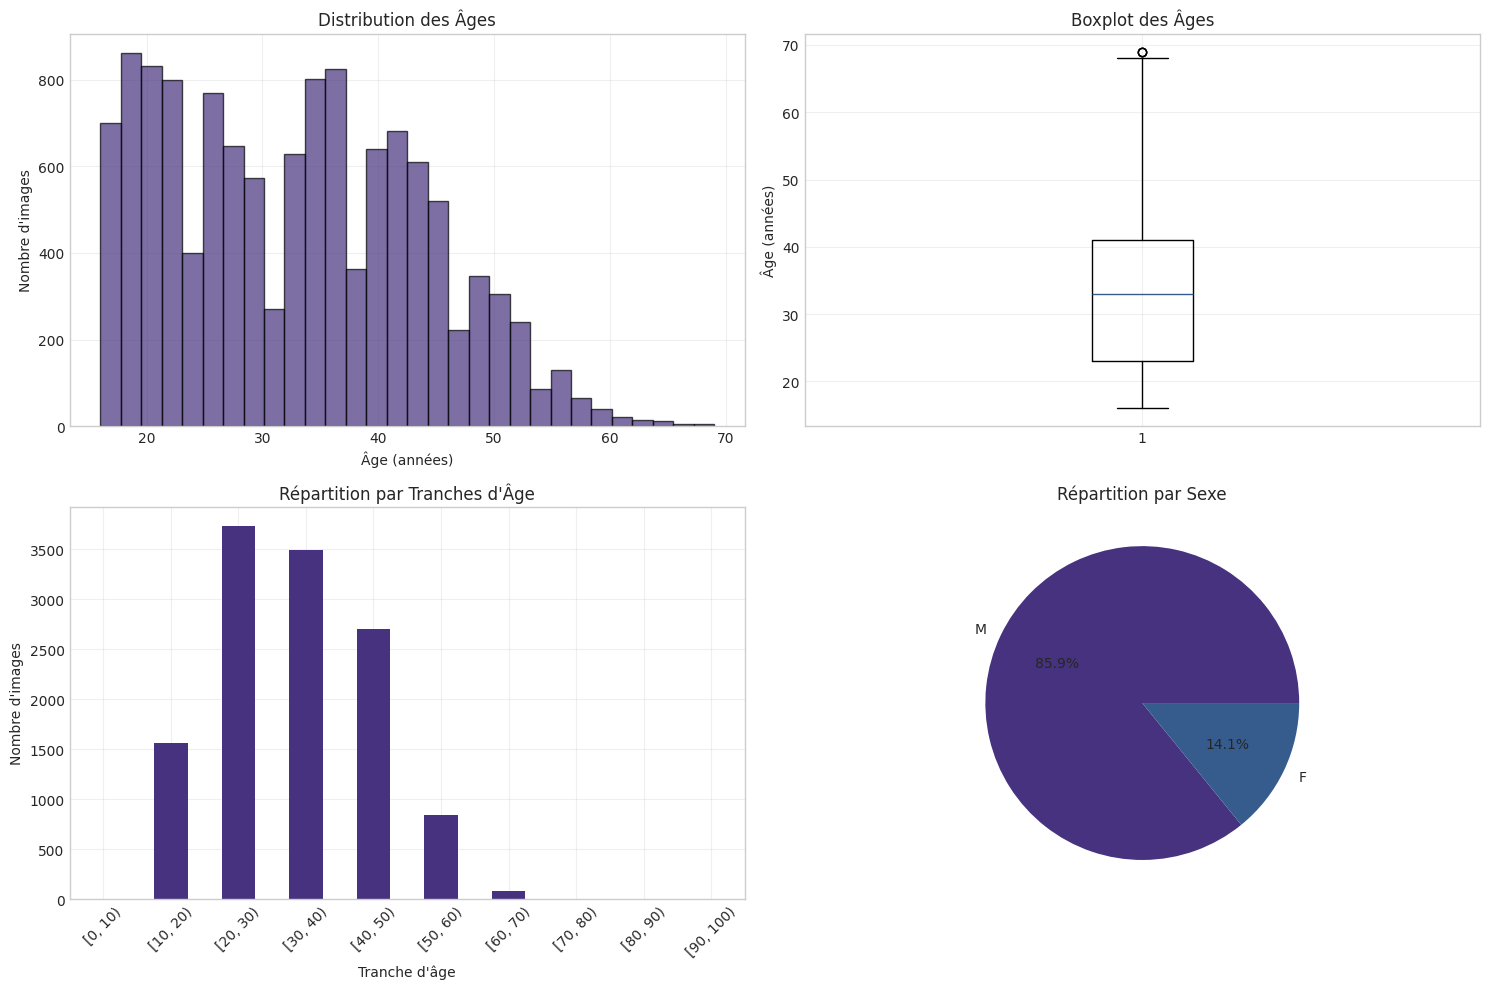


📊 ANALYSE PAR SEXE

Hommes (M):
  Nombre d'images: 10664
  Âge moyen: 32.7 ans
  Âge médian: 32.0 ans
  Écart-type: 11.0 ans
  Min-Max: 16-69 ans

Femmes (F):
  Nombre d'images: 1756
  Âge moyen: 33.2 ans
  Âge médian: 34.0 ans
  Écart-type: 10.0 ans
  Min-Max: 16-69 ans


In [30]:
if len(df_train) > 0:
    # Statistiques descriptives des âges
    print("📈 ANALYSE DE LA DISTRIBUTION DES ÂGES")
    print("="*50)
    
    print("Statistiques descriptives:")
    age_stats = df_train['age'].describe()
    print(age_stats)
    
    print(f"\nÂge minimum: {df_train['age'].min()} ans")
    print(f"Âge maximum: {df_train['age'].max()} ans")
    print(f"Âge médian: {df_train['age'].median()} ans")
    print(f"Âge moyen: {df_train['age'].mean():.1f} ans")
    
    # Visualisation de la distribution
    plt.figure(figsize=(15, 10))
    
    # Histogramme principal
    plt.subplot(2, 2, 1)
    plt.hist(df_train['age'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution des Âges')
    plt.xlabel('Âge (années)')
    plt.ylabel('Nombre d\'images')
    plt.grid(True, alpha=0.3)
    
    # Boxplot
    plt.subplot(2, 2, 2)
    plt.boxplot(df_train['age'])
    plt.title('Boxplot des Âges')
    plt.ylabel('Âge (années)')
    plt.grid(True, alpha=0.3)
    
    # Distribution par tranches d'âge
    plt.subplot(2, 2, 3)
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    df_train['age_group'] = pd.cut(df_train['age'], bins=age_bins, right=False)
    age_group_counts = df_train['age_group'].value_counts().sort_index()
    age_group_counts.plot(kind='bar', rot=45)
    plt.title('Répartition par Tranches d\'Âge')
    plt.xlabel('Tranche d\'âge')
    plt.ylabel('Nombre d\'images')
    plt.grid(True, alpha=0.3)
    
    # Distribution par sexe
    plt.subplot(2, 2, 4)
    gender_counts = df_train['gender'].value_counts()
    plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
    plt.title('Répartition par Sexe')
    
    plt.tight_layout()
    plt.show()
    
    # Analyse détaillée par sexe
    print("\n📊 ANALYSE PAR SEXE")
    print("="*30)
    for gender in ['M', 'F']:
        gender_data = df_train[df_train['gender'] == gender]['age']
        gender_name = 'Hommes' if gender == 'M' else 'Femmes'
        print(f"\n{gender_name} ({gender}):")
        print(f"  Nombre d'images: {len(gender_data)}")
        print(f"  Âge moyen: {gender_data.mean():.1f} ans")
        print(f"  Âge médian: {gender_data.median()} ans")
        print(f"  Écart-type: {gender_data.std():.1f} ans")
        print(f"  Min-Max: {gender_data.min()}-{gender_data.max()} ans")
else:
    print("❌ Aucune donnée disponible pour l'analyse.")

### 2.3 Analyse des personnes et photos multiples

👥 ANALYSE DES PERSONNES ET PHOTOS MULTIPLES
Nombre de personnes uniques: 8997
Nombre total d'images: 12420
Moyenne d'images par personne: 1.38

Distribution des photos par personne:
  Min: 1 photos
  Max: 10 photos
  Médiane: 1.0 photos
  Moyenne: 1.38 photos


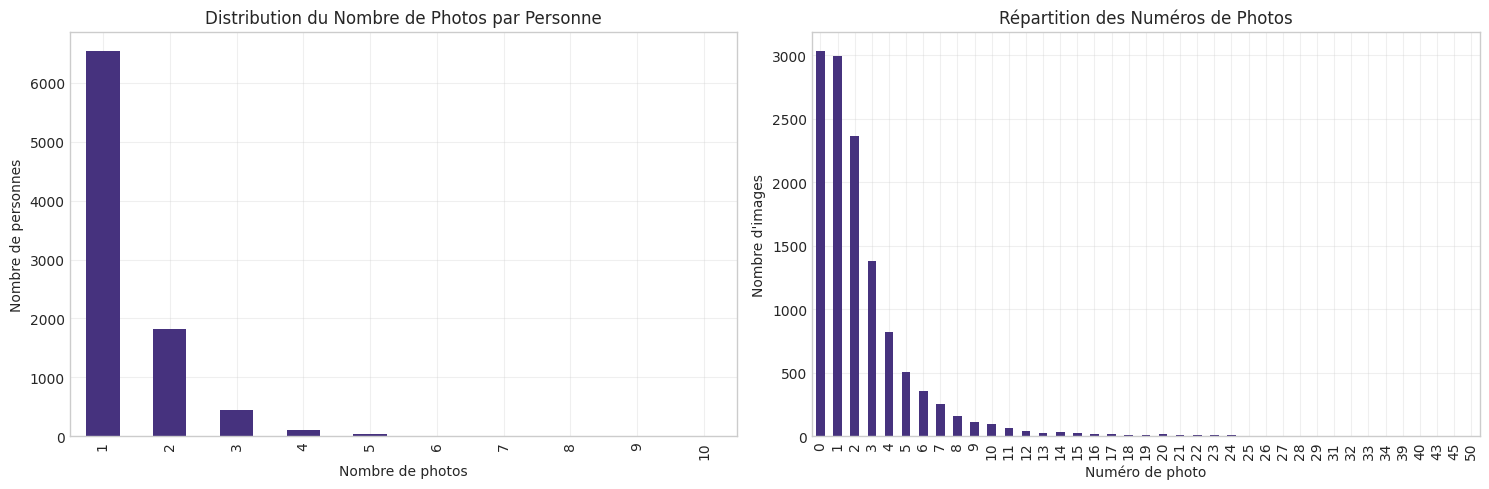


Exemples de personnes avec plusieurs photos:
  Personne 00022: 2 photos, âges: [19, 20], sexe: M
  Personne 0007: 3 photos, âges: [44, 17, 16], sexe: F
  Personne 0092: 2 photos, âges: [27, 24], sexe: F
  Personne 00978: 2 photos, âges: [35, 36], sexe: M
  Personne 01083: 2 photos, âges: [27, 25], sexe: M


In [31]:
if len(df_train) > 0:
    print("👥 ANALYSE DES PERSONNES ET PHOTOS MULTIPLES")
    print("="*50)
    
    # Nombre de personnes uniques
    unique_persons = df_train['person_id'].nunique()
    total_images = len(df_train)
    
    print(f"Nombre de personnes uniques: {unique_persons}")
    print(f"Nombre total d'images: {total_images}")
    print(f"Moyenne d'images par personne: {total_images/unique_persons:.2f}")
    
    # Analyse des photos par personne
    photos_per_person = df_train.groupby('person_id').size()
    
    print(f"\nDistribution des photos par personne:")
    print(f"  Min: {photos_per_person.min()} photos")
    print(f"  Max: {photos_per_person.max()} photos")
    print(f"  Médiane: {photos_per_person.median()} photos")
    print(f"  Moyenne: {photos_per_person.mean():.2f} photos")
    
    # Visualisation
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    photos_per_person.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution du Nombre de Photos par Personne')
    plt.xlabel('Nombre de photos')
    plt.ylabel('Nombre de personnes')
    plt.grid(True, alpha=0.3)
    
    # Analyse des numéros de photos
    plt.subplot(1, 2, 2)
    photo_num_counts = df_train['photo_num'].value_counts().sort_index()
    photo_num_counts.plot(kind='bar')
    plt.title('Répartition des Numéros de Photos')
    plt.xlabel('Numéro de photo')
    plt.ylabel('Nombre d\'images')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Exemples de personnes avec plusieurs photos
    multi_photo_persons = photos_per_person[photos_per_person > 1].head(5)
    if len(multi_photo_persons) > 0:
        print(f"\nExemples de personnes avec plusieurs photos:")
        for person_id, photo_count in multi_photo_persons.items():
            person_data = df_train[df_train['person_id'] == person_id]
            ages = person_data['age'].tolist()
            genders = person_data['gender'].tolist()
            print(f"  Personne {person_id}: {photo_count} photos, âges: {ages}, sexe: {genders[0]}")
else:
    print("❌ Aucune donnée disponible pour l'analyse.")

### 2.4 Visualisation d'exemples d'images par âge et sexe

🖼️ EXEMPLES D'IMAGES PAR ÂGE ET SEXE

Hommes (M):


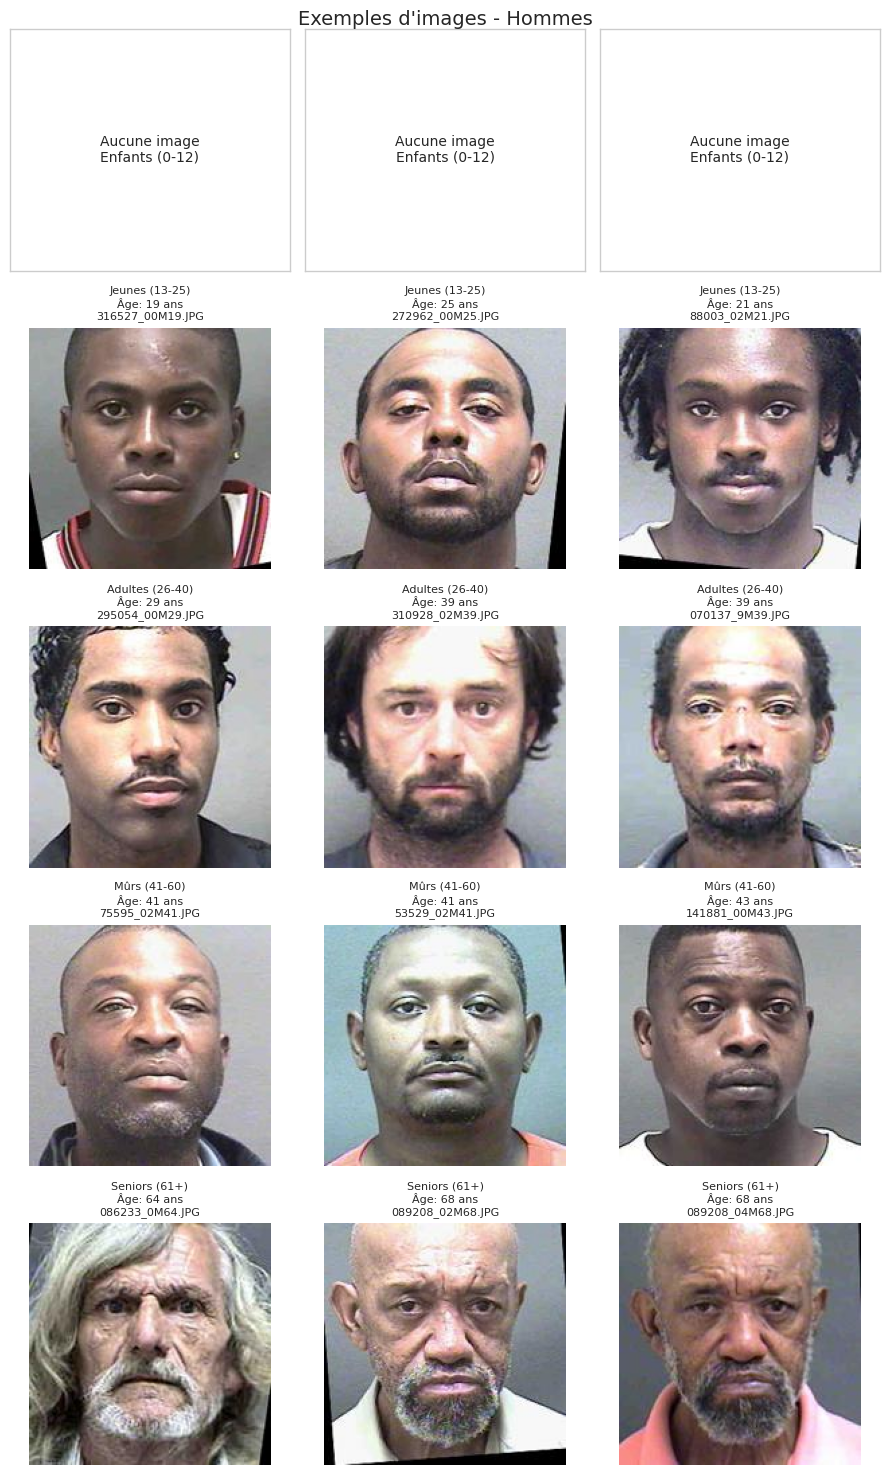


Femmes (F):


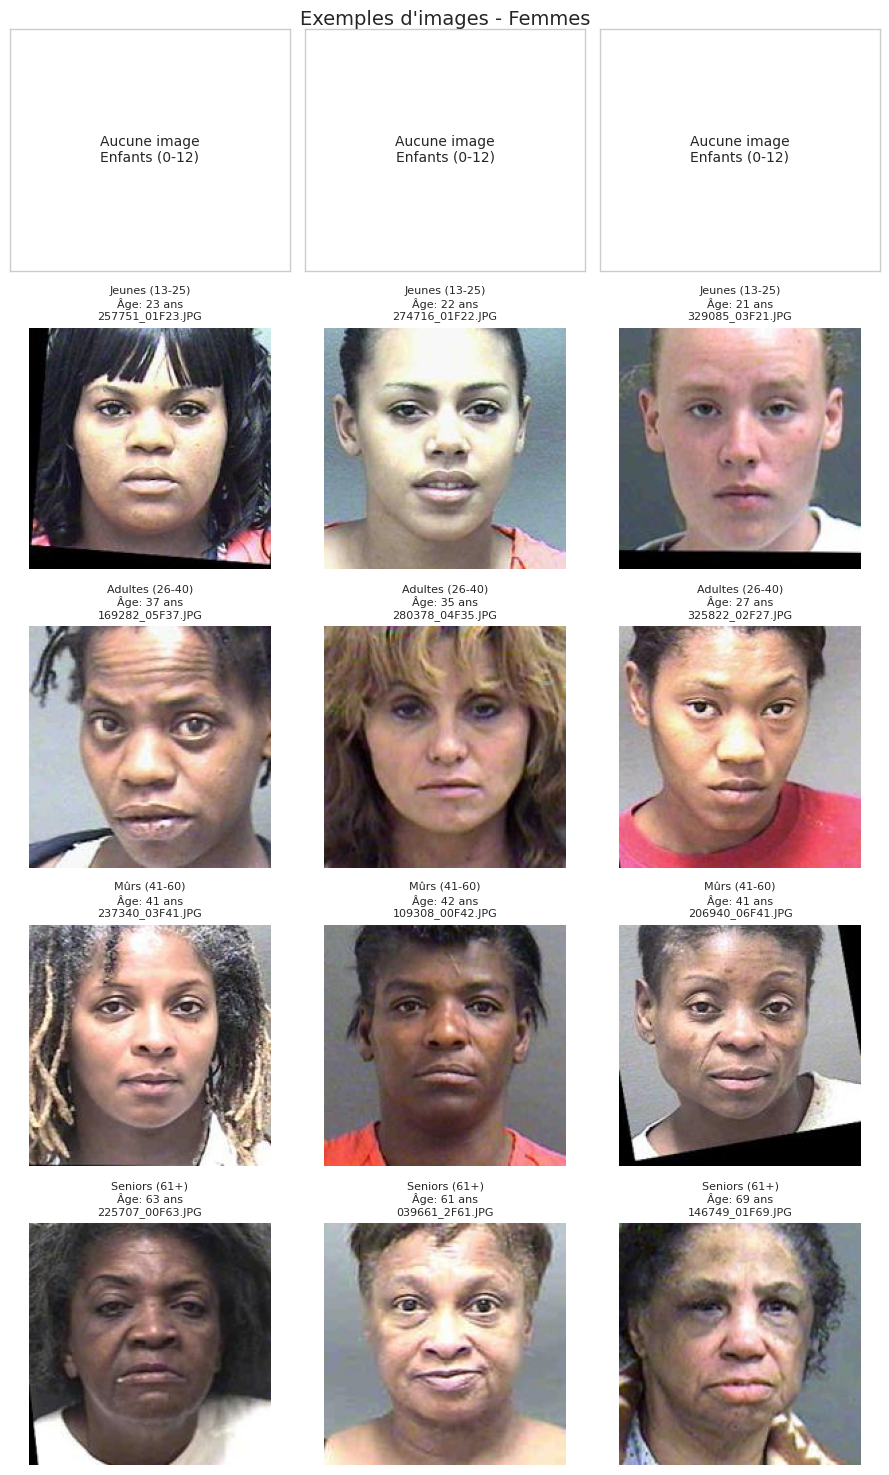

In [32]:
def show_sample_images_by_age_gender(df, num_samples=3):
    """
    Affiche des exemples d'images organisés par tranches d'âge et sexe
    """
    if len(df) == 0:
        print("❌ Aucune donnée disponible.")
        return
    
    # Définir des tranches d'âge représentatives
    age_ranges = [
        (0, 12, "Enfants (0-12)"),
        (13, 25, "Jeunes (13-25)"),
        (26, 40, "Adultes (26-40)"),
        (41, 60, "Mûrs (41-60)"),
        (61, 100, "Seniors (61+)")
    ]
    
    genders = [('M', 'Hommes'), ('F', 'Femmes')]
    
    print("🖼️ EXEMPLES D'IMAGES PAR ÂGE ET SEXE")
    print("="*50)
    
    for gender_code, gender_name in genders:
        print(f"\n{gender_name} ({gender_code}):")
        
        fig, axes = plt.subplots(len(age_ranges), num_samples, 
                                figsize=(num_samples*3, len(age_ranges)*3))
        
        if len(age_ranges) == 1:
            axes = [axes]
        if num_samples == 1:
            axes = [[ax] for ax in axes]
        
        for i, (min_age, max_age, age_label) in enumerate(age_ranges):
            # Filtrer les données pour cette tranche d'âge et ce sexe
            filtered_df = df[
                (df['gender'] == gender_code) & 
                (df['age'] >= min_age) & 
                (df['age'] <= max_age)
            ]
            
            if len(filtered_df) == 0:
                # Aucune image pour cette catégorie
                for j in range(num_samples):
                    axes[i][j].text(0.5, 0.5, f'Aucune image\n{age_label}', 
                                   ha='center', va='center', transform=axes[i][j].transAxes)
                    axes[i][j].set_xticks([])
                    axes[i][j].set_yticks([])
                continue
            
            # Sélectionner des échantillons aléatoirement
            samples = filtered_df.sample(n=min(num_samples, len(filtered_df)))
            
            for j, (_, row) in enumerate(samples.iterrows()):
                if j >= num_samples:
                    break
                    
                try:
                    # Charger et afficher l'image
                    img = Image.open(row['file_path'])
                    axes[i][j].imshow(img)
                    axes[i][j].set_title(f"{age_label}\nÂge: {row['age']} ans\n{row['filename']}", 
                                        fontsize=8)
                    axes[i][j].axis('off')
                except Exception as e:
                    axes[i][j].text(0.5, 0.5, f'Erreur\nchargement\n{e}', 
                                   ha='center', va='center', transform=axes[i][j].transAxes, 
                                   fontsize=8)
                    axes[i][j].set_xticks([])
                    axes[i][j].set_yticks([])
            
            # Remplir les axes vides s'il n'y a pas assez d'échantillons
            for j in range(len(samples), num_samples):
                axes[i][j].text(0.5, 0.5, 'Pas d\'autres\nimage', 
                               ha='center', va='center', transform=axes[i][j].transAxes)
                axes[i][j].set_xticks([])
                axes[i][j].set_yticks([])
        
        plt.suptitle(f'Exemples d\'images - {gender_name}', fontsize=14, y=0.98)
        plt.tight_layout()
        plt.show()

# Afficher les exemples
if len(df_train) > 0:
    show_sample_images_by_age_gender(df_train, num_samples=3)
else:
    print("❌ Aucune donnée disponible pour afficher des exemples.")